# 使用RNN和CNN处理序列

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 小批量个单变量时间序列 (batch_size, n_steps) wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)  # (batch_size, n_steps, 1)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]  # (7000, 50, 1), (7000, 1)
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


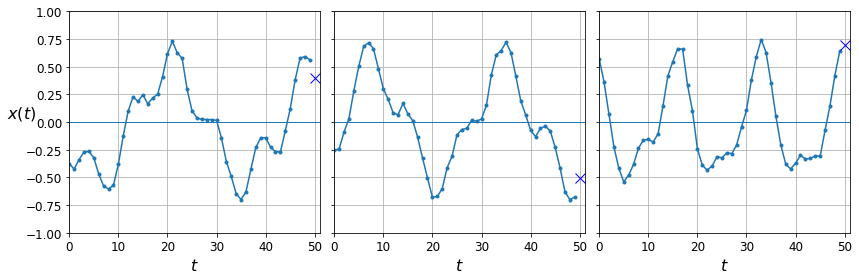

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value) 单纯预测

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

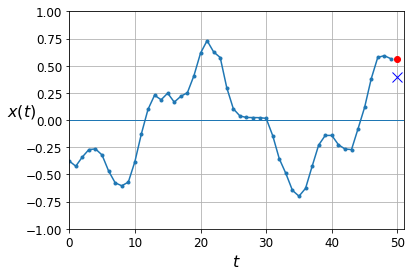

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

# 把单变量的时间序列展平作为全连接网络的输入(7000, 50, 1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), 
    keras.layers.Dense(1)])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 926us/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 715us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 727us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 703us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 692us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 722us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 710us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 731us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 698us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 807us/step - loss: 0.006

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 363us/step - loss: 0.0042


0.004168085753917694

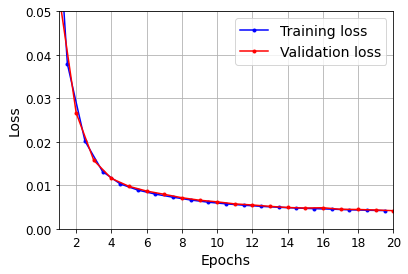

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

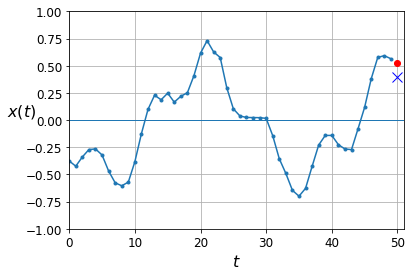

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])  # 只需要指定每个循环层有多少个循环神经元就可以，不用指定输入序列的长度--None
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0116 - val_loss: 0.011

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0109


0.010881561785936356

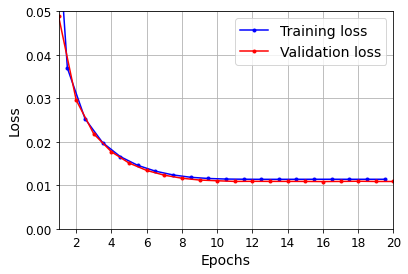

In [14]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

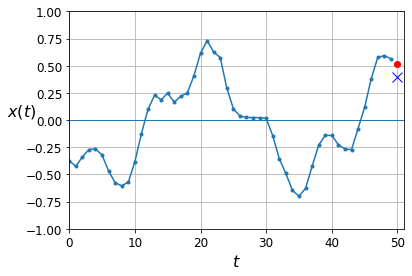

In [15]:
y_pred = model.predict(X_valid)  # (2000, 1) Keras中的循环层仅返回最终的输出
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.SimpleRNN(20, return_sequences=True), 
    keras.layers.SimpleRNN(1)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0035 - val_lo

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0029


0.0029105606954544783

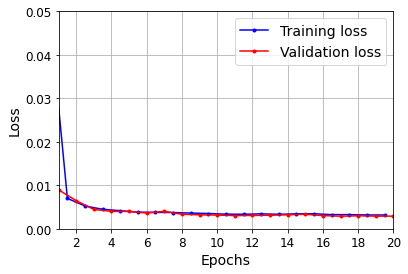

In [19]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

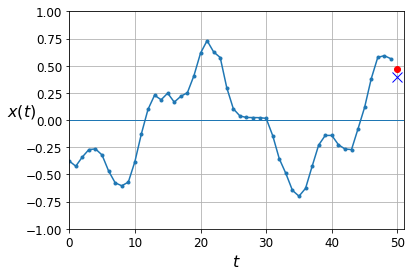

In [20]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second SimpleRNN layer return only the last output:

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0030 - val_lo

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0026


0.0026236246339976788

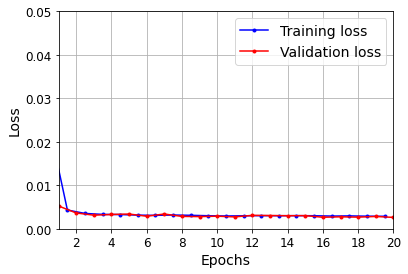

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

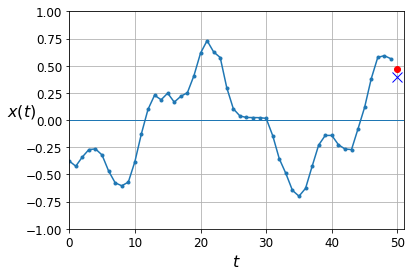

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

In [25]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new  # (1, 50, 1)
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
    
Y_pred = X[:, n_steps:]

In [26]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast ahead plot


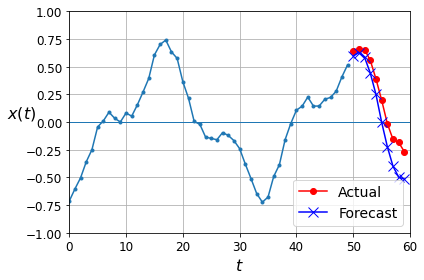

In [27]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    
    
plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast ahead plot")

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [28]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [29]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]  # RNN可以处理任意数量的时间步长
    X = np.concatenate([X, y_pred_one], axis=1)
    
Y_pred = X[:, n_steps:, 0]

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510818

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [31]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]), 
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20, 
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 814us/step - loss: 0.1343 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 713us/step - loss: 0.0496 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 699us/step - loss: 0.0385 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 682us/step - loss: 0.0331 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 684us/step - loss: 0.0298 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 664us/step - loss: 0.0273 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 680us/step - loss: 0.0256 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 701us/step - loss: 0.0244 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 682us/step - loss: 0.0234 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 671us/step - loss: 0.022

Now let's create an RNN that predicts all 10 next values at once:

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.SimpleRNN(20), 
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0110 - val_lo

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

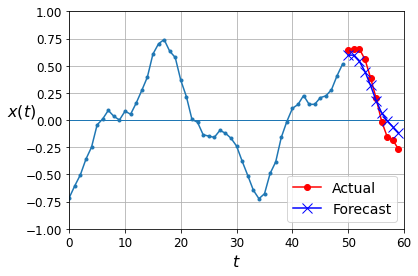

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [36]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)  # (10000, 60, 1)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))  # (10000, 50, 10) each target is a sequence of 10D vectors
for step_ahead in range(1, 10+1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]  # 这一行程序写得好
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [37]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.SimpleRNN(20, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))  # 重构输入的形状[批量大小 * 时间步长, 输入维度]
])


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [39]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, 
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0351 - val_last_time_step_mse: 0.0242
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0324 - last_time_step_mse: 0.0214 - val_loss: 0.0296 - val_last_time_step_mse: 0.0180
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0294 - last_time_step_mse: 0.0181 - val_loss: 0.0270 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0271 - last_time_step_mse: 0.0152 - val_loss: 0.0258 - val_last_time_step_mse: 0.0136
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0249 - last_time_step_mse: 0.0122 - val_loss: 0.0221 - val_last_time_step_mse: 0.0086
Epoch 7/20
219/219 [==

In [41]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

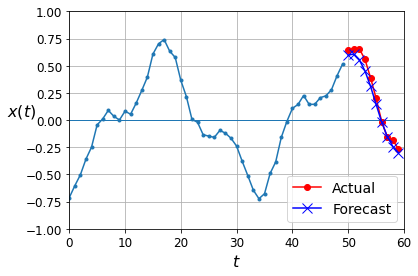

In [42]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Deep RNN with Batch Norm (记忆单元之间------垂直方向)

In [43]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.BatchNormalization(), 
    keras.layers.SimpleRNN(20, return_sequences=True), 
    keras.layers.BatchNormalization(), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, 
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 22ms/step - loss: 0.1929 - last_time_step_mse: 0.1902 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0537 - last_time_step_mse: 0.0449 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0471 - last_time_step_mse: 0.0375 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0437 - last_time_step_mse: 0.0337 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0409 - last_time_step_mse: 0.0306 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0385 - last_time_step_mse: 0.0275 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

## Deep RNN with Layer Norm (水平方向，在输入和隐藏状态的线性组合之后立即使用)

In [44]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units 
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [45]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]), 
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 54ms/step - loss: 0.1580 - last_time_step_mse: 0.1521 - val_loss: 0.0726 - val_last_time_step_mse: 0.0631
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0632 - last_time_step_mse: 0.0525 - val_loss: 0.0558 - val_last_time_step_mse: 0.0405
Epoch 3/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0523 - last_time_step_mse: 0.0350 - val_loss: 0.0497 - val_last_time_step_mse: 0.0326
Epoch 4/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0464 - last_time_step_mse: 0.0303 - val_loss: 0.0438 - val_last_time_step_mse: 0.0287
Epoch 5/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0422 - last_time_step_mse: 0.0274 - val_loss: 0.0409 - val_last_time_step_mse: 0.0251
Epoch 6/20
219/219 [==============================] - 12s 53ms/step - loss: 0.0388 - last_time_step_mse: 0.0239 - val_loss: 0.0366 - val_last_time_step_mse: 0.0207
Epoch 7/20
219/2

## Creating a Custom RNN Class

In [46]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, "get_initial_state", self.fallback_initial_state)
    
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 10s 48ms/step - loss: 0.2084 - last_time_step_mse: 0.2085 - val_loss: 0.0783 - val_last_time_step_mse: 0.0735
Epoch 2/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0700 - last_time_step_mse: 0.0636 - val_loss: 0.0637 - val_last_time_step_mse: 0.0574
Epoch 3/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0593 - last_time_step_mse: 0.0512 - val_loss: 0.0543 - val_last_time_step_mse: 0.0432
Epoch 4/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0511 - last_time_step_mse: 0.0394 - val_loss: 0.0483 - val_last_time_step_mse: 0.0363
Epoch 5/20
219/219 [==============================] - 10s 47ms/step - loss: 0.0465 - last_time_step_mse: 0.0344 - val_loss: 0.0448 - val_last_time_step_mse: 0.0332
Epoch 6/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0431 - last_time_step_mse: 0.0308 - val_loss: 0.0408 - val_last_time_step_mse: 0.0276
Epoch 7/20
219/2

## LSTMs

In [48]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.LSTM(20, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [========

In [49]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788686841726303, 0.008560805581510067]

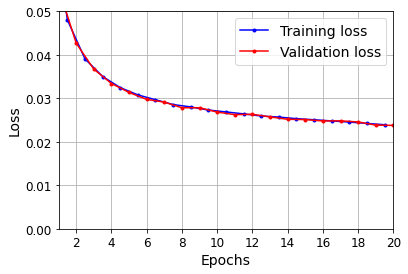

In [50]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [51]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

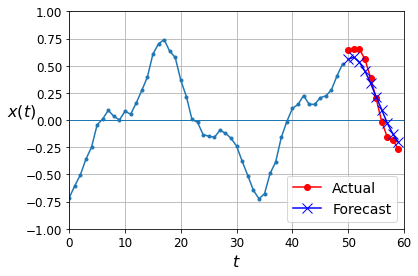

In [52]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRUs

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.GRU(20, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [========

In [54]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.02378549799323082, 0.0102628068998456]

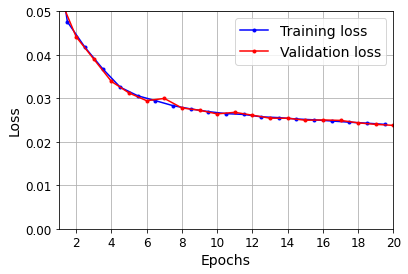

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [57]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

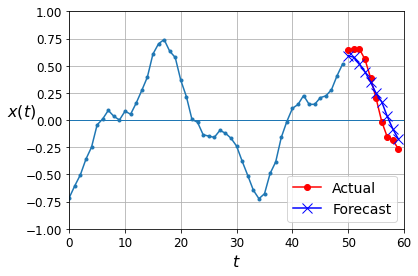

In [59]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49   一维卷积卷到哪个时间步长就预测这个时间步长
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50   以后的10个时间步长的值  
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [100]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid", input_shape=[50, 1]), 
    keras.layers.GRU(20, return_sequences=True), 
    keras.layers.GRU(20, return_sequences=True), 
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [101]:
model.summary()  # GRU的可训练参数个数为什么总是多了 units * 3 ???

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 24, 20)            100       
_________________________________________________________________
gru_15 (GRU)                 (None, 24, 20)            2520      
_________________________________________________________________
gru_16 (GRU)                 (None, 24, 20)            2520      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 24, 10)            210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, 
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0681 - last_time_step_mse: 0.0601 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0414 - last_time_step_mse: 0.0340 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0338 - last_time_step_mse: 0.0257 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0282 - last_time_step_mse: 0.0184 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0249 - last_time_step_mse: 0.0143 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0234 - last_time_step_mse: 0.0125 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [========

In [83]:
model = keras.models.Sequential()
model.add(keras.layers.GRU(7, batch_input_shape=(None, None, 2)))
model.summary()  # GRU的可训练参数个数为什么总是多了 units * 3 ???

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, 7)                 231       
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [84]:
model = keras.models.Sequential()
model.add(keras.layers.GRU(7, batch_input_shape=(None, None, 10)))
model.summary()  # GRU的可训练参数个数为什么总是多了 units * 3 ???

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 7)                 399       
Total params: 399
Trainable params: 399
Non-trainable params: 0
_________________________________________________________________


## Wave Net

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [119]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal', 
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

In [120]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 20)          60        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 20)          8

In [121]:
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, 
          validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0667 - last_time_step_mse: 0.0543 - val_loss: 0.0373 - val_last_time_step_mse: 0.0239
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0335 - last_time_step_mse: 0.0212 - val_loss: 0.0310 - val_last_time_step_mse: 0.0192
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0295 - last_time_step_mse: 0.0178 - val_loss: 0.0284 - val_last_time_step_mse: 0.0170
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0274 - last_time_step_mse: 0.0158 - val_loss: 0.0269 - val_last_time_step_mse: 0.0161
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0259 - last_time_step_mse: 0.0142 - val_loss: 0.0254 - val_last_time_step_mse: 0.0139
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0250 - last_time_step_mse: 0.0133 - val_loss: 0.0242 - val_last_time_step_mse: 0.0126
Epoch 7/20
219/219 [========

In [122]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0194 - last_time_step_mse: 0.0080


[0.01940687745809555, 0.008019563741981983]

In [124]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

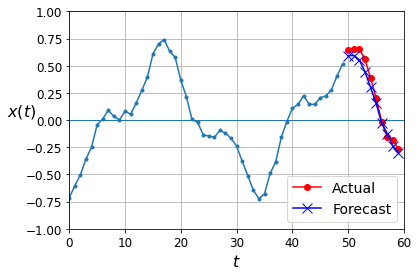

In [125]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [102]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [103]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    # 时间步长保持不变，在左侧填充正确数量的零且使用"valid"填充
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)  # 特征数量减半
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [111]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3
n_blocks = 1
n_filters = 32
n_outputs = 10

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)  # (None, None, 32)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [112]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     96          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     4160        conv1d[0][0]                     
__________________________________________________________________________________________________
gated_activation_unit (GatedAct (None, None, 32)     0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [114]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1215 - last_time_step_mse: 0.1172 - val_loss: 0.1213 - val_last_time_step_mse: 0.1184
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1212 - last_time_step_mse: 0.1169 - val_loss: 0.1211 - val_last_time_step_mse: 0.1183
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1210 - last_time_step_mse: 0.1167 - val_loss: 0.1209 - val_last_time_step_mse: 0.1182
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.1208 - last_time_step_mse: 0.1165 - val_loss: 0.1207 - val_last_time_step_mse: 0.1179
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1207 - last_time_step_mse: 0.1164 - val_loss: 0.1207 - val_last_time_step_mse: 0.1179
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1206 - last_time_step_mse: 0.1163 - val_loss: 0.1205 - val_last_time_step_mse: 0.1177
Epoch 7/20
219/219 [========